In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# For Decision Trees and Random Forest
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import roc_auc_score, matthews_corrcoef, accuracy_score, classification_report, confusion_matrix

# EDA and Pre-processing

## Merging Tables

In [2]:
# Read all datasets
orders_df = pd.read_csv('olist_orders_dataset.csv')
order_items_df = pd.read_csv('olist_order_items_dataset.csv')
products_df = pd.read_csv('olist_products_dataset.csv')
customers_df = pd.read_csv('olist_customers_dataset.csv')
sellers_df = pd.read_csv('olist_sellers_dataset.csv')
geolocation_df = pd.read_csv('olist_geolocation_dataset.csv')

# Process geolocation data
geolocation_unique = geolocation_df.groupby('geolocation_zip_code_prefix').first().reset_index()[
    ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']
]

# Process customer location data
customers_with_location = customers_df.merge(
    geolocation_unique,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='inner'
)[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 
   'customer_city', 'customer_state', 'geolocation_lat', 'geolocation_lng']].rename(columns={
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng'
})

# Process seller location data
sellers_with_location = sellers_df.merge(
    geolocation_unique,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='inner'
)[['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state',
   'geolocation_lat', 'geolocation_lng']].rename(columns={
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng'
})

# Merge order items with products (only necessary columns)
order_items_with_products = order_items_df.merge(
    products_df[['product_id', 'product_weight_g', 'product_length_cm', 
                'product_height_cm', 'product_width_cm']],
    on='product_id',
    how='inner'
)

# Add seller information to order items
order_items_complete = order_items_with_products.merge(
    sellers_with_location,
    on='seller_id',
    how='inner'
)

# Build final dataset
# 1. Start with orders
data = orders_df.merge(
    customers_with_location,
    on='customer_id',
    how='inner'
)

# 2. Add order items and seller information
data = data.merge(
    order_items_complete,
    on='order_id',
    how='inner'
)

# Print information about the dataset
print("Final dataset shape:", data.shape)
print("\nColumns in final dataset:")
print(data.columns.tolist())

# Show example of multiple items in an order
print("\nExample of an order with multiple items:")
sample_order = data.groupby('order_id').size().sort_values(ascending=False).index[0]
print(data[data['order_id'] == sample_order][
    ['order_id', 'order_item_id', 'seller_id', 'price', 'freight_value']
].head())

Final dataset shape: (112096, 29)

Columns in final dataset:
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'customer_lat', 'customer_lng', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'seller_lat', 'seller_lng']

Example of an order with multiple items:
                                order_id  order_item_id  \
100028  8272b63d03f5f79c56e9e4120aec44ef              1   
100029  8272b63d03f5f79c56e9e4120aec44ef              2   
100030  8272b63d03f5f79c56e9e4120aec44ef              3   
100031  8272b63d03f5f79c56e9e4120aec44ef              4   
100032  8272b63d03f5f79c56e9e4120a

In [3]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,8.72,500.0,19.0,8.0,13.0,9350,maua,SP,-23.680114,-46.452454
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,22.76,400.0,19.0,13.0,19.0,31570,belo horizonte,SP,-19.810119,-43.984727
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,19.22,420.0,24.0,19.0,21.0,14840,guariba,SP,-21.362358,-48.232976
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,27.20,450.0,30.0,10.0,20.0,31842,belo horizonte,MG,-19.840168,-43.923299
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,8.72,250.0,51.0,15.0,15.0,8752,mogi das cruzes,SP,-23.551707,-46.260979


In [4]:
print(data["freight_value"].nunique())

6989


In [5]:
print(data.duplicated().sum())

0


## Creating a Customer and Seller Variable
- Instead of having two columns for customer location (city and state) and two other for seller, we combine them into one.

In [6]:
# Combine customer city and state into one column
data['customer_location'] = data['customer_city'] + ', ' + data['customer_state']

# Combine seller city and state into one column
data['seller_location'] = data['seller_city'] + ', ' + data['seller_state']

# Display the updated DataFrame
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,customer_location,seller_location
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,19.0,8.0,13.0,9350,maua,SP,-23.680114,-46.452454,"sao paulo, SP","maua, SP"
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,19.0,13.0,19.0,31570,belo horizonte,SP,-19.810119,-43.984727,"barreiras, BA","belo horizonte, SP"
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,24.0,19.0,21.0,14840,guariba,SP,-21.362358,-48.232976,"vianopolis, GO","guariba, SP"
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,30.0,10.0,20.0,31842,belo horizonte,MG,-19.840168,-43.923299,"sao goncalo do amarante, RN","belo horizonte, MG"
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,51.0,15.0,15.0,8752,mogi das cruzes,SP,-23.551707,-46.260979,"santo andre, SP","mogi das cruzes, SP"


## Dropping Columns

In [7]:
# Drop the specified columns
data = data.drop(columns=[
    'order_id',
    'customer_id',
    'seller_id',
    'customer_city',
    'customer_state',
    'seller_city',
    'seller_state'
])

# Display the first few rows to confirm the columns are dropped
data.head()

,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_lat,customer_lng,...,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_lat,seller_lng,customer_location,seller_location
0,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,-23.574809,-46.587471,...,8.72,500.0,19.0,8.0,13.0,9350,-23.680114,-46.452454,"sao paulo, SP","maua, SP"
1,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,-12.169860,-44.988369,...,22.76,400.0,19.0,13.0,19.0,31570,-19.810119,-43.984727,"barreiras, BA","belo horizonte, SP"
2,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,-16.746337,-48.514624,...,19.22,420.0,24.0,19.0,21.0,14840,-21.362358,-48.232976,"vianopolis, GO","guariba, SP"
3,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,-5.767733,-35.275467,...,27.20,450.0,30.0,10.0,20.0,31842,-19.840168,-43.923299,"sao goncalo do amarante, RN","belo horizonte, MG"
4,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,-23.675037,-46.524784,...,8.72,250.0,51.0,15.0,15.0,8752,-23.551707,-46.260979,"santo andre, SP","mogi das cruzes, SP"


In [8]:
data["order_status"].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'canceled',
       'unavailable', 'approved'], dtype=object)

- Since we are predicting late delivery, it makes sense to only keep orderes with an `order_status == 'delivered'`

In [9]:
# Filter for only delivered orders
data = data[data['order_status'] == 'delivered']

data.head()

,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_lat,customer_lng,...,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_lat,seller_lng,customer_location,seller_location
0,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,-23.574809,-46.587471,...,8.72,500.0,19.0,8.0,13.0,9350,-23.680114,-46.452454,"sao paulo, SP","maua, SP"
1,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,-12.169860,-44.988369,...,22.76,400.0,19.0,13.0,19.0,31570,-19.810119,-43.984727,"barreiras, BA","belo horizonte, SP"
2,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,-16.746337,-48.514624,...,19.22,420.0,24.0,19.0,21.0,14840,-21.362358,-48.232976,"vianopolis, GO","guariba, SP"
3,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,-5.767733,-35.275467,...,27.20,450.0,30.0,10.0,20.0,31842,-19.840168,-43.923299,"sao goncalo do amarante, RN","belo horizonte, MG"
4,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,-23.675037,-46.524784,...,8.72,250.0,51.0,15.0,15.0,8752,-23.551707,-46.260979,"santo andre, SP","mogi das cruzes, SP"


In [10]:
# Drop the `order_status` column since we no longer need it
data = data.drop(columns='order_status')

## Finding distance between buyer and seller

In [11]:
# Earth radius in kilometers
R = 6371

# Convert latitude and longitude from degrees to radians
data['geolocation_lat_rad'] = np.radians(data['customer_lat'])
data['geolocation_lng_rad'] = np.radians(data['customer_lng'])
data['seller_lat_rad'] = np.radians(data['seller_lat'])
data['seller_lng_rad'] = np.radians(data['seller_lng'])

# Haversine formula
data['distance_km'] = 2 * R * np.arcsin(np.sqrt(
    np.sin((data['seller_lat_rad'] - data['geolocation_lat_rad']) / 2) ** 2 +
    np.cos(data['geolocation_lat_rad']) * np.cos(data['seller_lat_rad']) *
    np.sin((data['seller_lng_rad'] - data['geolocation_lng_rad']) / 2) ** 2
))

# Drop the temporary radian columns and the unnecessary latitude and longitude columns (since we already calcualted the distance)
data = data.drop(columns=['geolocation_lat_rad', 'geolocation_lng_rad', 'seller_lat_rad', 'seller_lng_rad','seller_lat', 'seller_lng', 'customer_lat', 'customer_lng'])

# Display the first few rows to confirm
data[['distance_km']].head()

,distance_km
0,18.063837
1,856.292580
2,514.130333
3,1822.800366
4,30.174037


In [12]:
data.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,order_item_id,product_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,customer_location,seller_location,distance_km
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,1,87285b34884572647811a353c7ac498a,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,9350,"sao paulo, SP","maua, SP",18.063837
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,1,595fac2a385ac33a80bd5114aec74eb8,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,31570,"barreiras, BA","belo horizonte, SP",856.292580
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,1,aa4383b373c6aca5d8797843e5594415,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,14840,"vianopolis, GO","guariba, SP",514.130333
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,1,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-23 19:45:59,45.00,27.20,450.0,30.0,10.0,20.0,31842,"sao goncalo do amarante, RN","belo horizonte, MG",1822.800366
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,1,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-19 20:31:37,19.90,8.72,250.0,51.0,15.0,15.0,8752,"santo andre, SP","mogi das cruzes, SP",30.174037


In [13]:
print(data["freight_value"].nunique())

len(data["freight_value"])


6914


109661

## Finding the Distance (in hours) between when an order was approved and when it was shipped
- The goal is to find the distance between `order_approved_at` and `order_delivered_carrier_date` in hours
- When we use the feature imporatance from our classification model, we can see how much this variable contributes to the prediction

In [14]:
# Ensure datetime format for the relevant columns
data['order_approved_at'] = pd.to_datetime(data['order_approved_at'])
data['order_delivered_carrier_date'] = pd.to_datetime(data['order_delivered_carrier_date'])

# Calculate the time difference in hours
data['time_to_ship_hours'] = (data['order_delivered_carrier_date'] - data['order_approved_at']).dt.total_seconds() / 3600

data = data.drop(columns=['order_approved_at',
                          'order_delivered_carrier_date'])

In [15]:
# Display the updated DataFrame
data.head()

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,order_item_id,product_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,customer_location,seller_location,distance_km,time_to_ship_hours
0,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,1,87285b34884572647811a353c7ac498a,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,9350,"sao paulo, SP","maua, SP",18.063837,56.795833
1,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,1,595fac2a385ac33a80bd5114aec74eb8,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,31570,"barreiras, BA","belo horizonte, SP",856.292580,11.109167
2,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,1,aa4383b373c6aca5d8797843e5594415,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,14840,"vianopolis, GO","guariba, SP",514.130333,4.910278
3,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,1,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-23 19:45:59,45.00,27.20,450.0,30.0,10.0,20.0,31842,"sao goncalo do amarante, RN","belo horizonte, MG",1822.800366,89.900000
4,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,1,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-19 20:31:37,19.90,8.72,250.0,51.0,15.0,15.0,8752,"santo andre, SP","mogi das cruzes, SP",30.174037,21.434722


## Create `product_volume` variable
- This is the product of `product_weight_g`, `product_length_cm`, and `product_height_cm`

In [16]:
# Create the new variable 'product_volume'
data['product_volume'] = data['product_weight_g'] * data['product_length_cm'] * data['product_height_cm']

data.head()

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,order_item_id,product_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,customer_location,seller_location,distance_km,time_to_ship_hours,product_volume
0,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,1,87285b34884572647811a353c7ac498a,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,9350,"sao paulo, SP","maua, SP",18.063837,56.795833,76000.0
1,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,1,595fac2a385ac33a80bd5114aec74eb8,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,31570,"barreiras, BA","belo horizonte, SP",856.292580,11.109167,98800.0
2,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,1,aa4383b373c6aca5d8797843e5594415,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,14840,"vianopolis, GO","guariba, SP",514.130333,4.910278,191520.0
3,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,1,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-23 19:45:59,45.00,27.20,450.0,30.0,10.0,20.0,31842,"sao goncalo do amarante, RN","belo horizonte, MG",1822.800366,89.900000,135000.0
4,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,1,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-19 20:31:37,19.90,8.72,250.0,51.0,15.0,15.0,8752,"santo andre, SP","mogi das cruzes, SP",30.174037,21.434722,191250.0


## Create `season` varaible
- This variable looks at the season on which the other was placed

In [17]:
# Ensure 'order_purchase_timestamp' is in datetime format
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

# Define a function to assign seasons based on the month
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Apply the function to create a new 'season' column
data['season'] = data['order_purchase_timestamp'].dt.month.apply(assign_season)

# Display the first few rows to verify
data.head()

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,order_item_id,product_id,shipping_limit_date,price,freight_value,...,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,customer_location,seller_location,distance_km,time_to_ship_hours,product_volume,season
0,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,1,87285b34884572647811a353c7ac498a,2017-10-06 11:07:15,29.99,8.72,...,19.0,8.0,13.0,9350,"sao paulo, SP","maua, SP",18.063837,56.795833,76000.0,Fall
1,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,1,595fac2a385ac33a80bd5114aec74eb8,2018-07-30 03:24:27,118.70,22.76,...,19.0,13.0,19.0,31570,"barreiras, BA","belo horizonte, SP",856.292580,11.109167,98800.0,Summer
2,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,1,aa4383b373c6aca5d8797843e5594415,2018-08-13 08:55:23,159.90,19.22,...,24.0,19.0,21.0,14840,"vianopolis, GO","guariba, SP",514.130333,4.910278,191520.0,Summer
3,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,1,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-23 19:45:59,45.00,27.20,...,30.0,10.0,20.0,31842,"sao goncalo do amarante, RN","belo horizonte, MG",1822.800366,89.900000,135000.0,Fall
4,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,1,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-19 20:31:37,19.90,8.72,...,51.0,15.0,15.0,8752,"santo andre, SP","mogi das cruzes, SP",30.174037,21.434722,191250.0,Winter


## Create Outcome Variabel
- The outcome variable is whether the order was late or not. The way this is estimated is through comparing the actual delivery date to the estimated delivery date.
- If the delivery date is after the estimated delivery date, then an order is late (1).
If the delivery date is before or on the estimated delivery date, it is on time (0).

In [18]:
# Making sure all dates are in the same format
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])
data['order_estimated_delivery_date'] = pd.to_datetime(data['order_estimated_delivery_date'])

# Create binary outcome variable (1 if late, 0 if on-time or early)
data['is_late'] = (data['order_delivered_customer_date'] > data['order_estimated_delivery_date']).astype(int)

# Drop the date columns now that is_late has been created
data = data.drop(columns=['order_delivered_customer_date', 'order_estimated_delivery_date'])

# Display the first few rows to confirm
data.head()

,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,order_item_id,product_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,customer_location,seller_location,distance_km,time_to_ship_hours,product_volume,season,is_late
0,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,1,87285b34884572647811a353c7ac498a,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,9350,"sao paulo, SP","maua, SP",18.063837,56.795833,76000.0,Fall,0
1,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,47813,1,595fac2a385ac33a80bd5114aec74eb8,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,31570,"barreiras, BA","belo horizonte, SP",856.292580,11.109167,98800.0,Summer,0
2,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,75265,1,aa4383b373c6aca5d8797843e5594415,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,14840,"vianopolis, GO","guariba, SP",514.130333,4.910278,191520.0,Summer,0
3,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,59296,1,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-23 19:45:59,45.00,27.20,450.0,30.0,10.0,20.0,31842,"sao goncalo do amarante, RN","belo horizonte, MG",1822.800366,89.900000,135000.0,Fall,0
4,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,9195,1,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-19 20:31:37,19.90,8.72,250.0,51.0,15.0,15.0,8752,"santo andre, SP","mogi das cruzes, SP",30.174037,21.434722,191250.0,Winter,0


## Create Weekend Variable

- From `order_purchase_timestamp`, we can extract whether the order was placed on a weekend or weekday to be a feature. After extracting that information, we can drop the original column.



In [19]:
# Ensure the timestamp column is in datetime format
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

# Create the weekend_order column: 1 if the order was placed on a weekend, 0 otherwise
data['weekend_order'] = data['order_purchase_timestamp'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

# Drop the original order_purchase_timestamp column
data = data.drop(columns=['order_purchase_timestamp'])

# Display the first few rows to confirm
data.head()

,customer_unique_id,customer_zip_code_prefix,order_item_id,product_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,customer_location,seller_location,distance_km,time_to_ship_hours,product_volume,season,is_late,weekend_order
0,7c396fd4830fd04220f754e42b4e5bff,3149,1,87285b34884572647811a353c7ac498a,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,9350,"sao paulo, SP","maua, SP",18.063837,56.795833,76000.0,Fall,0,0
1,af07308b275d755c9edb36a90c618231,47813,1,595fac2a385ac33a80bd5114aec74eb8,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,31570,"barreiras, BA","belo horizonte, SP",856.292580,11.109167,98800.0,Summer,0,0
2,3a653a41f6f9fc3d2a113cf8398680e8,75265,1,aa4383b373c6aca5d8797843e5594415,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,14840,"vianopolis, GO","guariba, SP",514.130333,4.910278,191520.0,Summer,0,0
3,7c142cf63193a1473d2e66489a9ae977,59296,1,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-23 19:45:59,45.00,27.20,450.0,30.0,10.0,20.0,31842,"sao goncalo do amarante, RN","belo horizonte, MG",1822.800366,89.900000,135000.0,Fall,0,1
4,72632f0f9dd73dfee390c9b22eb56dd6,9195,1,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-19 20:31:37,19.90,8.72,250.0,51.0,15.0,15.0,8752,"santo andre, SP","mogi das cruzes, SP",30.174037,21.434722,191250.0,Winter,0,0


- Now dropping the last two columns: `order_approved_at` and `order_delivered_carrier_date`

## Robustness Checks

- We want to see how many late orders there are in the data set.
- We can see that there is a class imbalnce

In [20]:
data["is_late"].value_counts()
print(f"The frequency of late orders is {data['is_late'].value_counts()[1]}")
print(f"The ratio of late orders is {(data['is_late'].value_counts()[1])/len(data):.3f}\n")

print(f"The frequency of on-time orders is {data['is_late'].value_counts()[0]}")
print(f"The ratio of on-time orders is {(data['is_late'].value_counts()[0])/len(data):.3f}")

The frequency of late orders is 8662
The ratio of late orders is 0.079

The frequency of on-time orders is 100999
The ratio of on-time orders is 0.921


In [21]:
print(f"The frequency of weekend orders is {data['weekend_order'].value_counts()[1]}")
print(f"The ratio of weekend orders is {(data['weekend_order'].value_counts()[1])/len(data):.3f}\n")

print(f"The frequency of weekday orders is {data['weekend_order'].value_counts()[0]}")
print(f"The ratio of weekday orders is {(data['weekend_order'].value_counts()[0])/len(data):.3f}")

The frequency of weekend orders is 24886
The ratio of weekend orders is 0.227

The frequency of weekday orders is 84775
The ratio of weekday orders is 0.773


### Exploring the `time_to_ship_hours` Variable

- In the `time_to_ship_hours` variable, we want to esure that the values are logical. i.e. non-negative. Recall that the we obtained this vairable is by subtracting the time an order was approved from the time an order was shipped. Therefore, it would not make sense for an order to ship before it is approved.

In [22]:
negative_shipping = data[data['time_to_ship_hours'] < 0]
negative_shipping.head(10)

,customer_unique_id,customer_zip_code_prefix,order_item_id,product_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,customer_location,seller_location,distance_km,time_to_ship_hours,product_volume,season,is_late,weekend_order
16,ccafc1c3f270410521c3c6f3b249870f,74820,1,009c09f439988bc06a93d6b8186dce73,2018-06-18 18:59:02,132.4,14.05,150.0,20.0,20.0,20.0,71931,"goiania, GO","brasilia, DF",161.604604,-32.617222,60000.0,Summer,0,0
68,0e764fc1a13e47e900c3d59a989753e8,36045,1,d1c427060a0f73f6b889a5c7c61f2ac4,2018-04-26 09:31:11,119.0,24.97,6550.0,20.0,20.0,20.0,37175,"juiz de fora, MG","ilicinea, MG",270.188017,-23.102222,2620000.0,Spring,0,1
69,0e764fc1a13e47e900c3d59a989753e8,36045,2,db56f6d2b04c89eae4daba188842fd7b,2018-04-26 09:31:11,199.0,3.12,12450.0,40.0,25.0,57.0,30111,"juiz de fora, MG","belo horizonte, MG",211.404885,-23.102222,12450000.0,Spring,0,1
235,a5314ac290a8b141491e987ae37aa7cc,13454,1,1613b819ab5dae53aead2dbb4ebdb378,2018-07-26 03:45:26,27.9,7.46,50.0,17.0,10.0,15.0,12940,"santa barbara d'oeste, SP","atibaia, SP",94.351073,-58.581389,8500.0,Summer,0,1
246,95aec963a6193f24401417870b648031,7600,1,d04bbac48960ecb7ea311b00ca6e1cb7,2018-07-25 11:03:54,102.0,38.88,11325.0,18.0,105.0,30.0,7074,"mairipora, SP","guarulhos, SP",14.903037,-0.131389,21404250.0,Summer,0,1
470,d9e85480c2442fce7b1c6e09db3b0492,11680,1,ab1f9387c0627dd24000bfbc54fdeee0,2018-07-26 04:10:15,19.9,12.80,175.0,22.0,11.0,16.0,1212,"ubatuba, SP","sao paulo, SP",159.512429,-81.469167,42350.0,Summer,0,1
545,196fbfa6f817924c4e13687eef22fb30,2078,1,6d0d7c2d9a4b8b79dbc12c47c74349dd,2018-07-06 17:31:30,59.0,13.07,300.0,18.0,9.0,12.0,16200,"sao paulo, SP","birigui, SP",455.563854,-1.718333,48600.0,Summer,0,0
546,196fbfa6f817924c4e13687eef22fb30,2078,2,6d0d7c2d9a4b8b79dbc12c47c74349dd,2018-07-06 17:31:30,59.0,13.07,300.0,18.0,9.0,12.0,16200,"sao paulo, SP","birigui, SP",455.563854,-1.718333,48600.0,Summer,0,0
548,cd2624b9b75d83efb640f7204232511e,4753,1,de533fe5b9448ea9792195806938dbf5,2018-07-31 12:55:27,196.8,12.40,1650.0,35.0,23.0,35.0,3204,"sao paulo, SP","sao paulo, SP",17.366226,-80.747778,1328250.0,Summer,0,0
668,c3818f2a1aa9b856afa2cc5adf8e97b7,78652,1,4a1ccd2d546bbea7809a0cf98863eb50,2018-05-11 16:52:39,189.9,53.46,900.0,25.0,50.0,30.0,99500,"confresa, MT","carazinho, RS",1966.055012,-1.727500,1125000.0,Spring,0,0


In [23]:
negative_shipping["time_to_ship_hours"].describe()

count    1534.000000
mean      -24.791802
std       109.170797
min     -4109.256111
25%       -26.260833
50%       -17.500278
75%        -1.440347
max        -0.005833
Name: time_to_ship_hours, dtype: float64

- Notice, from above, that there are values of approximatly -4000 hours. Meaning that some orders shipped 4000 hours before it was approved which just does not make any sense.

In [24]:
negative_shipping["is_late"].value_counts()

is_late
0    1499
1      35
Name: count, dtype: int64

- We have a total of 8662 late orders, and only 35 are associated with negative values in the `time_to_ship_hours` variable. Therefore, we choose to drop those rows.

In [25]:
# Drop rows where 'time_to_ship_hours' is negative
data = data[data['time_to_ship_hours'] >= 0]

# Confirm the rows with negative values are removed
print(data['time_to_ship_hours'].min())

0.004166666666666667


In [26]:
# Checking how many late orders after dropping the negative shipping

data[data["is_late"]==0].value_counts().sum()

99466

### Other Variables

- Other variables are non-negative which is reassuring.

In [27]:
print(data["freight_value"].min())
print(data["product_weight_g"].min())
print(data["product_length_cm"].min())
print(data["product_height_cm"].min())
print(data["product_width_cm"].min())

0.0
0.0
7.0
2.0
6.0


# Visualization

## Top 10 Cities by Orders

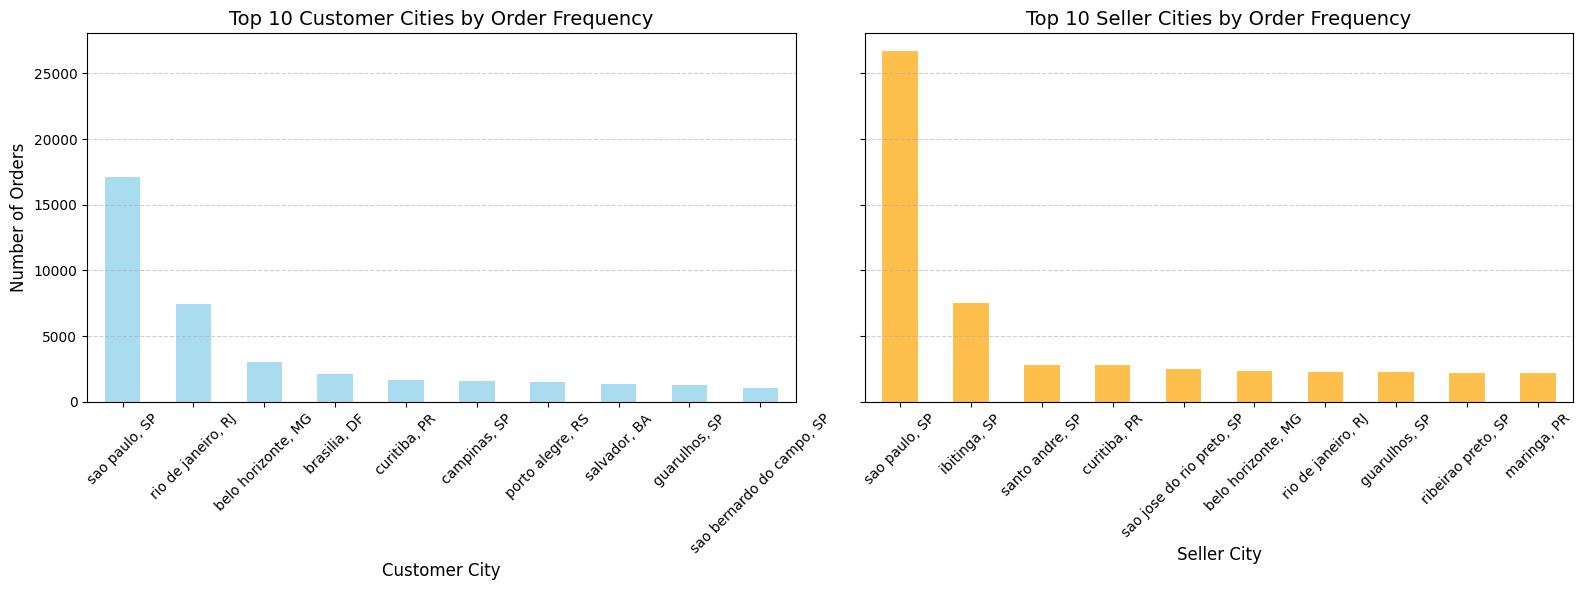

In [28]:
# Calculate the top 10 customer cities by order frequency
top_customer_cities = data['customer_location'].value_counts().head(10)

# Calculate the top 10 seller cities by order frequency
top_seller_cities = data['seller_location'].value_counts().head(10)

# Create side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for customer cities
top_customer_cities.plot(kind='bar', color='skyblue', alpha=0.7, ax=axes[0])
axes[0].set_title('Top 10 Customer Cities by Order Frequency', fontsize=14)
axes[0].set_xlabel('Customer City', fontsize=12)
axes[0].set_ylabel('Number of Orders', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot for seller cities
top_seller_cities.plot(kind='bar', color='orange', alpha=0.7, ax=axes[1])
axes[1].set_title('Top 10 Seller Cities by Order Frequency', fontsize=14)
axes[1].set_xlabel('Seller City', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Add gridlines to both plots
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()
plt.show()

## Top 10 Cities where orders are late

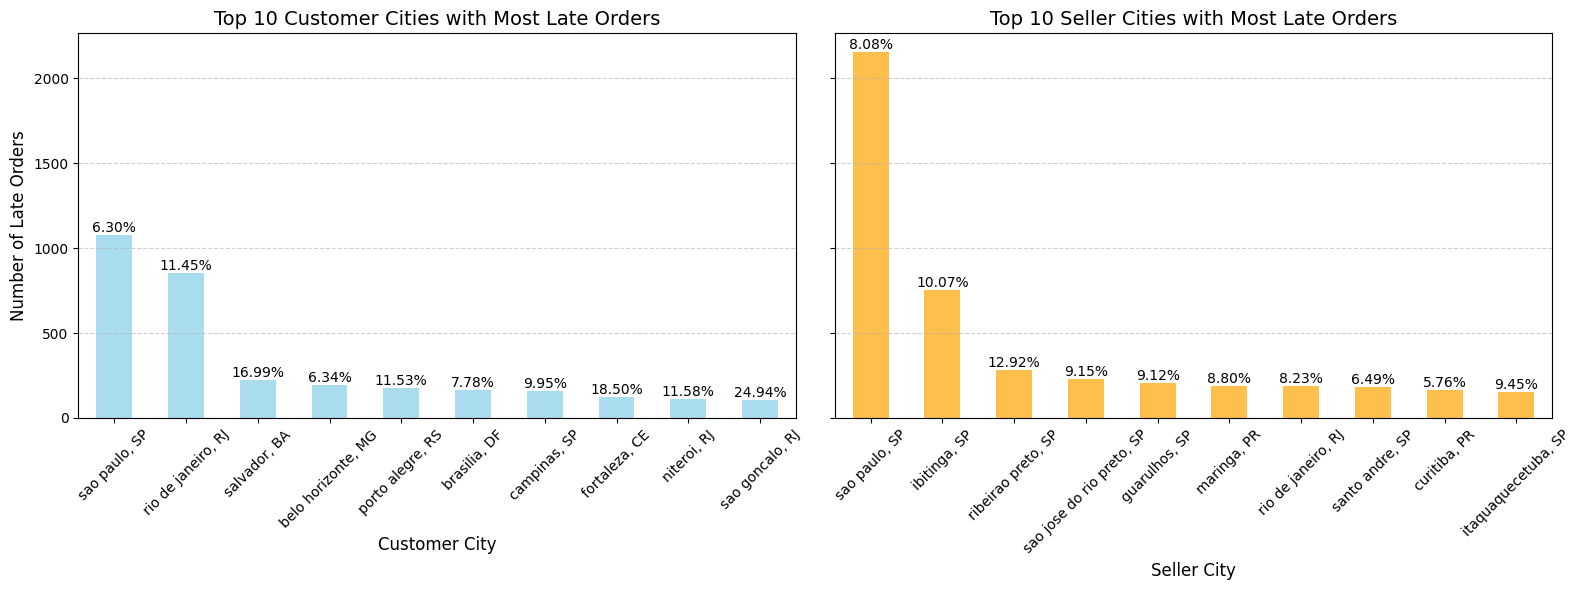

In [29]:
# Calculate total orders per customer location and seller location
total_customer_orders = data['customer_location'].value_counts()
total_seller_orders = data['seller_location'].value_counts()

# Filter data to include only late orders
late_orders = data[data['is_late'] == 1]

# Calculate the top 10 customer cities with the most late orders
top_customer_cities = late_orders['customer_location'].value_counts().head(10)
customer_proportions = (top_customer_cities / total_customer_orders[top_customer_cities.index])

# Calculate the top 10 seller cities with the most late orders
top_seller_cities = late_orders['seller_location'].value_counts().head(10)
seller_proportions = (top_seller_cities / total_seller_orders[top_seller_cities.index])

# Create side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for customer cities
top_customer_cities.plot(kind='bar', color='skyblue', alpha=0.7, ax=axes[0])
axes[0].set_title('Top 10 Customer Cities with Most Late Orders', fontsize=14)
axes[0].set_xlabel('Customer City', fontsize=12)
axes[0].set_ylabel('Number of Late Orders', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Annotate proportions on top of customer city bars
for i, val in enumerate(top_customer_cities):
    axes[0].text(i, val, f"{customer_proportions.iloc[i]:.2%}", ha='center', va='bottom', fontsize=10)

# Plot for seller cities
top_seller_cities.plot(kind='bar', color='orange', alpha=0.7, ax=axes[1])
axes[1].set_title('Top 10 Seller Cities with Most Late Orders', fontsize=14)
axes[1].set_xlabel('Seller City', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Annotate proportions on top of seller city bars
for i, val in enumerate(top_seller_cities):
    axes[1].text(i, val, f"{seller_proportions.iloc[i]:.2%}", ha='center', va='bottom', fontsize=10)

# Add gridlines to both plots
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()
plt.show()

In [30]:
data["customer_location"].value_counts().sort_values(ascending= True).head()

customer_location
nova vicosa, BA               1
cerejeiras, RO                1
sao joao de petropolis, ES    1
girau do ponciano, AL         1
groairas, CE                  1
Name: count, dtype: int64

In [31]:
# Calculate the customer location order counts
customer_order_counts = data['customer_location'].value_counts()

# Identify cities with 3 or fewer total orders
low_order_cities = customer_order_counts[customer_order_counts <= 3].index

# Filter data for orders in these cities
low_order_data = data[data['customer_location'].isin(low_order_cities)]

# Count the number of late orders in these cities
late_orders_in_low_order_cities = low_order_data[low_order_data['is_late'] == 1].shape[0]

print(f"The number of late orders from cities with 3 or fewer orders is {late_orders_in_low_order_cities}.")

The number of late orders from cities with 3 or fewer orders is 325.


## Distribution of Time to Ship (hours)


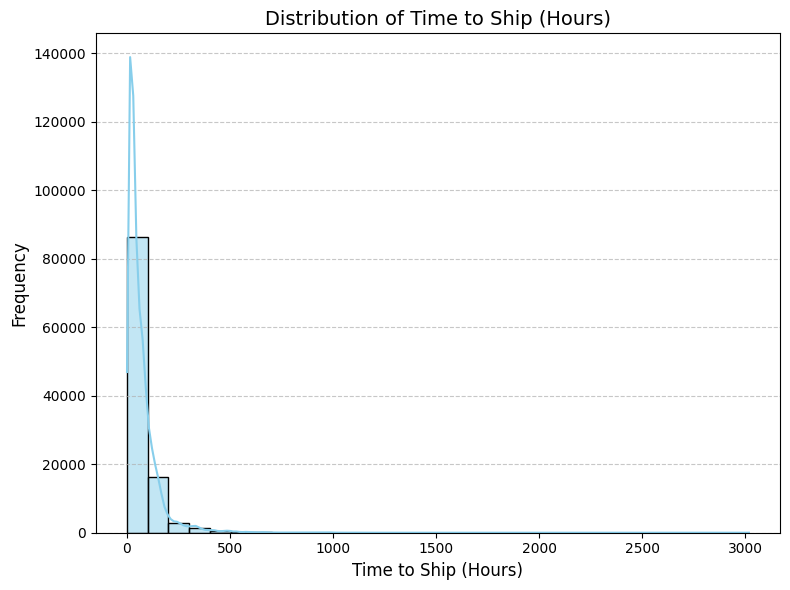

In [32]:
plt.figure(figsize=(8, 6))
sns.histplot(data['time_to_ship_hours'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Time to Ship (Hours)', fontsize=14)
plt.xlabel('Time to Ship (Hours)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- The time to ship hours goes to 3000 hours (125 days) which are often orders that are lost or have speacial circumstances

In [33]:
# Count values greater than or equal to 500
count_gte_500 = (data['time_to_ship_hours'] >= 500)

# Print the result
print(f"Number of values greater than or equal to 500: {count_gte_500.sum()}")

Number of values greater than or equal to 500: 618


In [34]:
# Count values where 'time_to_ship_hours' >= 500 and 'is_late' == 1
count_gte_500_late = data[(data['time_to_ship_hours'] >= 500) & (data['is_late'] == 1)]

# Print the result
print(f"Number of late orders with 'time_to_ship_hours' >= 500: {len(count_gte_500_late)}")

Number of late orders with 'time_to_ship_hours' >= 500: 363


- Given that out of the ~600 orders that took 500 hours or more to ship, ~360 were late. It may be unwise to drop all of these values. However, below, we visualize the `time_to_ship_hours` variable with a limit on 500 (125 days) hours or less.

- There are approximately 600 orders that took 500 hours or more to ship. Only about 350 (60%) of those orders are late. It is plausible that someone placed an order for a future (more than 500 hours) delivery date. Moreover, there may be industrial items which take time to ship. Therefore, it would be unwise to assume that all orders that took 500 hours or more to ship are automatically late.

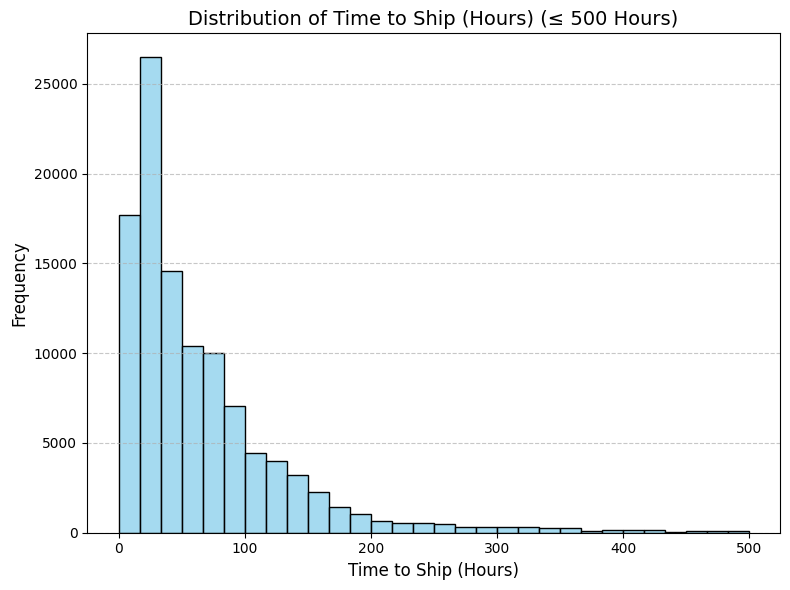

In [35]:
# Filter data for 'time_to_ship_hours' <= 500
time_to_ship_500 = data[data['time_to_ship_hours'] <= 500]

# Plot the distribution with adjusted KDE bandwidth
plt.figure(figsize=(8, 6))
sns.histplot(time_to_ship_500['time_to_ship_hours'], bins=30, color='skyblue')
plt.title('Distribution of Time to Ship (Hours) (≤ 500 Hours)', fontsize=14)
plt.xlabel('Time to Ship (Hours)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Late Orders by Distance


/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_69746/2118441121.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_late', y='distance_km', data=data, palette='Set2')


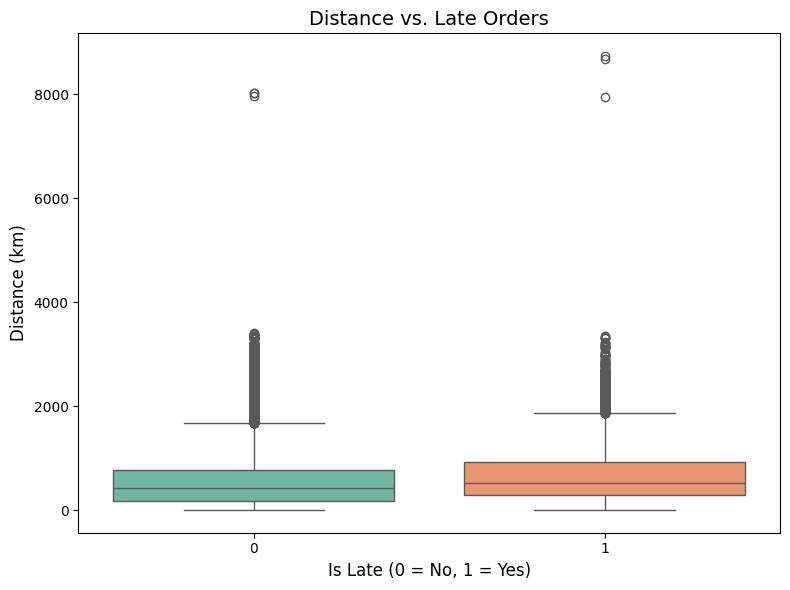

In [36]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_late', y='distance_km', data=data, palette='Set2')
plt.title('Distance vs. Late Orders', fontsize=14)
plt.xlabel('Is Late (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Distance (km)', fontsize=12)
plt.tight_layout()
plt.show()

- While distance does not drastically differ for late vs. on-time orders in general, there is a pattern where longer distances are more frequently associated with late orders. 

## Late Orders Based on Dimensions

/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_69746/352321530.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_late', y='product_length_cm', data=data, ax=axes[0, 0], palette='Set3')
/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_69746/352321530.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_late', y='product_height_cm', data=data, ax=axes[0, 1], palette='Set3')
/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_69746/352321530.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_la

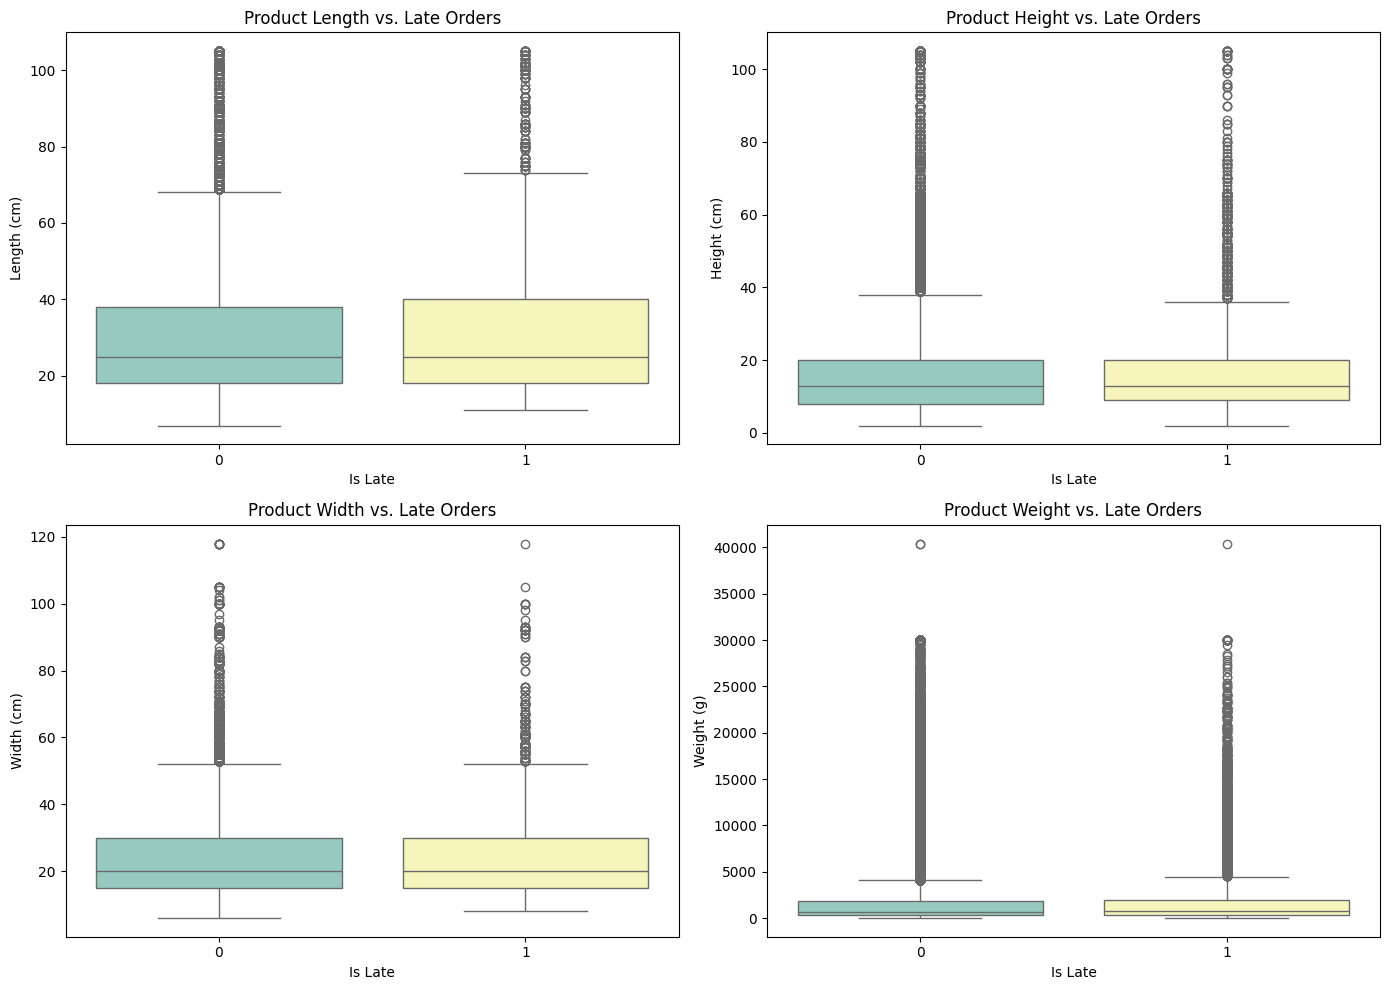

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Product Length vs. Late Orders
sns.boxplot(x='is_late', y='product_length_cm', data=data, ax=axes[0, 0], palette='Set3')
axes[0, 0].set_title('Product Length vs. Late Orders', fontsize=12)
axes[0, 0].set_xlabel('Is Late')
axes[0, 0].set_ylabel('Length (cm)')

# Product Height vs. Late Orders
sns.boxplot(x='is_late', y='product_height_cm', data=data, ax=axes[0, 1], palette='Set3')
axes[0, 1].set_title('Product Height vs. Late Orders', fontsize=12)
axes[0, 1].set_xlabel('Is Late')
axes[0, 1].set_ylabel('Height (cm)')

# Product Width vs. Late Orders
sns.boxplot(x='is_late', y='product_width_cm', data=data, ax=axes[1, 0], palette='Set3')
axes[1, 0].set_title('Product Width vs. Late Orders', fontsize=12)
axes[1, 0].set_xlabel('Is Late')
axes[1, 0].set_ylabel('Width (cm)')

# Product Weight vs. Late Orders
sns.boxplot(x='is_late', y='product_weight_g', data=data, ax=axes[1, 1], palette='Set3')
axes[1, 1].set_title('Product Weight vs. Late Orders', fontsize=12)
axes[1, 1].set_xlabel('Is Late')
axes[1, 1].set_ylabel('Weight (g)')

plt.tight_layout()
plt.show()

## Number of Late Orders by Season

/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_69746/1295149157.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=late_orders_per_season.index, y=late_orders_per_season.values, palette='Set3')


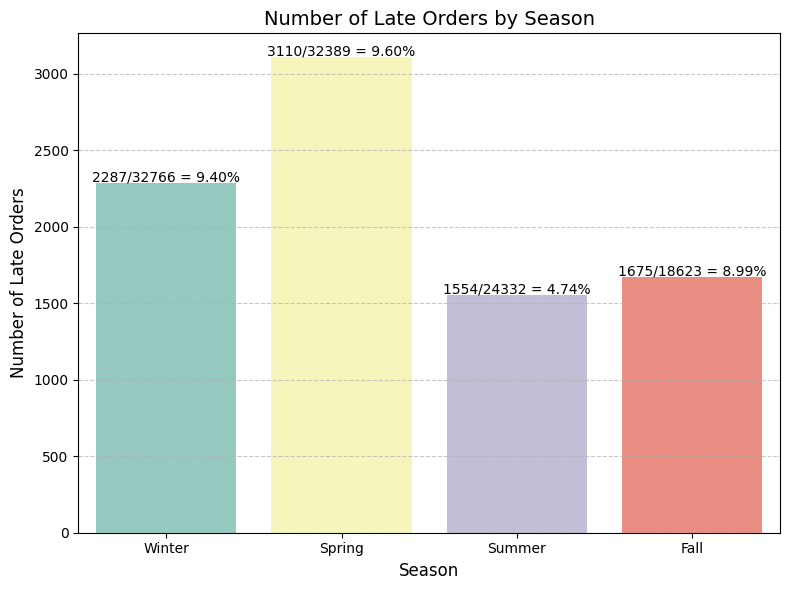

In [38]:
# Filter for late orders
late_orders = data[data['is_late'] == 1]

# Count the number of late orders for each season
late_orders_per_season = late_orders['season'].value_counts()

# Total orders per season (for proportion calculation)
total_orders_per_season = data['season'].value_counts()

# Calculate proportions of late orders for each season
proportion_late_orders = late_orders_per_season / total_orders_per_season

# Sort seasons for better order (Winter, Spring, Summer, Fall)
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
late_orders_per_season = late_orders_per_season.reindex(season_order)
proportion_late_orders = proportion_late_orders.reindex(season_order)

# Plot the number of late orders for each season
plt.figure(figsize=(8, 6))
sns.barplot(x=late_orders_per_season.index, y=late_orders_per_season.values, palette='Set3')

# Add proportions on top of bars with plain text
for i, val in enumerate(late_orders_per_season.values):
    num_late_orders = val
    total_orders = total_orders_per_season.iloc[i]
    ratio = proportion_late_orders.iloc[i]
    plt.text(
        i, val + 10, 
        f"{num_late_orders}/{total_orders} = {ratio:.2%}", 
        ha='center', fontsize=10
    )

# Titles and labels
plt.title('Number of Late Orders by Season', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Late Orders', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### One-Hot Encoding Seasons

In [39]:
# One-hot encode the 'season' column, excluding 'Spring'
season_dummies = pd.get_dummies(data['season'], drop_first=True)

# Convert True/False to 0/1 explicitly
season_dummies = season_dummies.astype(int)

# Concatenate the original DataFrame with the one-hot encoded columns
data = pd.concat([data, season_dummies], axis=1)

# Display the first few rows to verify
data.head()

,customer_unique_id,customer_zip_code_prefix,order_item_id,product_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,...,seller_location,distance_km,time_to_ship_hours,product_volume,season,is_late,weekend_order,Spring,Summer,Winter
0,7c396fd4830fd04220f754e42b4e5bff,3149,1,87285b34884572647811a353c7ac498a,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,...,"maua, SP",18.063837,56.795833,76000.0,Fall,0,0,0,0,0
1,af07308b275d755c9edb36a90c618231,47813,1,595fac2a385ac33a80bd5114aec74eb8,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,...,"belo horizonte, SP",856.292580,11.109167,98800.0,Summer,0,0,0,1,0
2,3a653a41f6f9fc3d2a113cf8398680e8,75265,1,aa4383b373c6aca5d8797843e5594415,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,...,"guariba, SP",514.130333,4.910278,191520.0,Summer,0,0,0,1,0
3,7c142cf63193a1473d2e66489a9ae977,59296,1,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-23 19:45:59,45.00,27.20,450.0,30.0,10.0,...,"belo horizonte, MG",1822.800366,89.900000,135000.0,Fall,0,1,0,0,0
4,72632f0f9dd73dfee390c9b22eb56dd6,9195,1,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-19 20:31:37,19.90,8.72,250.0,51.0,15.0,...,"mogi das cruzes, SP",30.174037,21.434722,191250.0,Winter,0,0,0,0,1


In [40]:
round((data["is_late"] == 0).sum()/data.shape[0]*100,3)

92.021

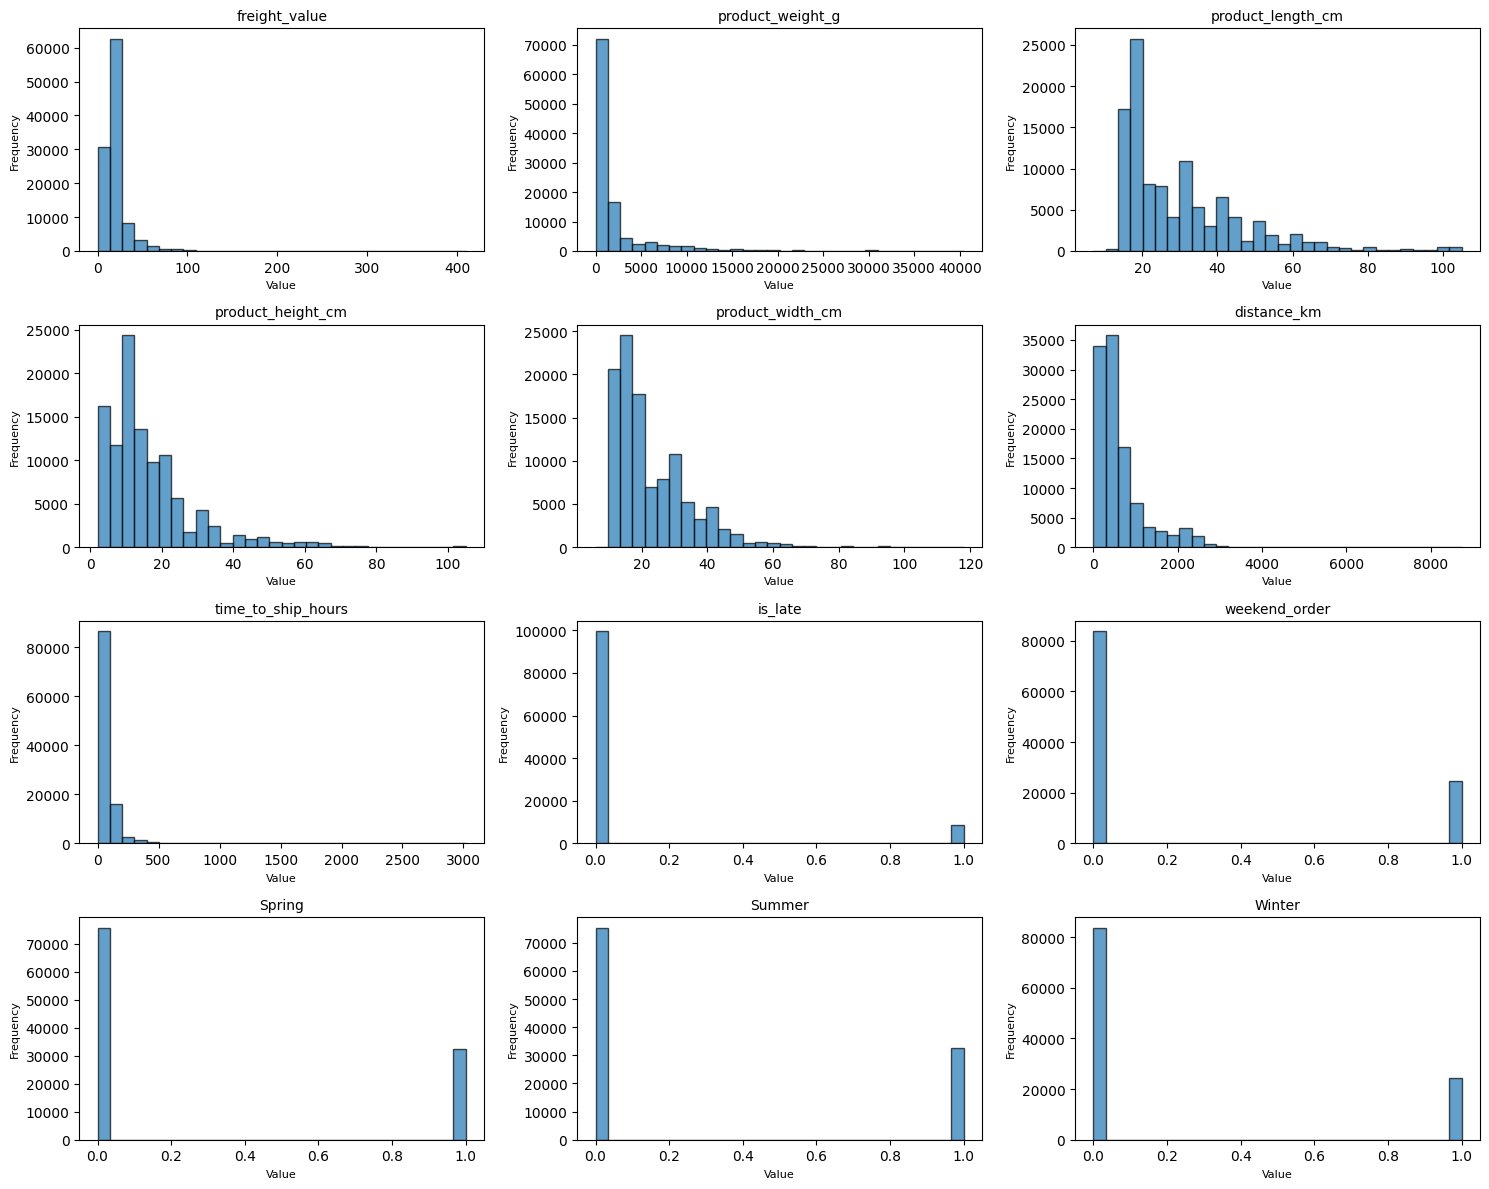

In [41]:
# Variables to plot
variables = data.drop(columns=["customer_location", "seller_location", "season",
                                "product_volume", "customer_unique_id", "customer_zip_code_prefix",
                                "order_item_id", "product_id", "shipping_limit_date",
                                "price", "seller_zip_code_prefix"])

# Number of variables
num_vars = variables.shape[1]

# Create 4x3 subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each variable
for i, col in enumerate(variables.columns):
    axes[i].hist(variables[col], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel('Value', fontsize=8)
    axes[i].set_ylabel('Frequency', fontsize=8)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Modeling

## Correlation Matrix

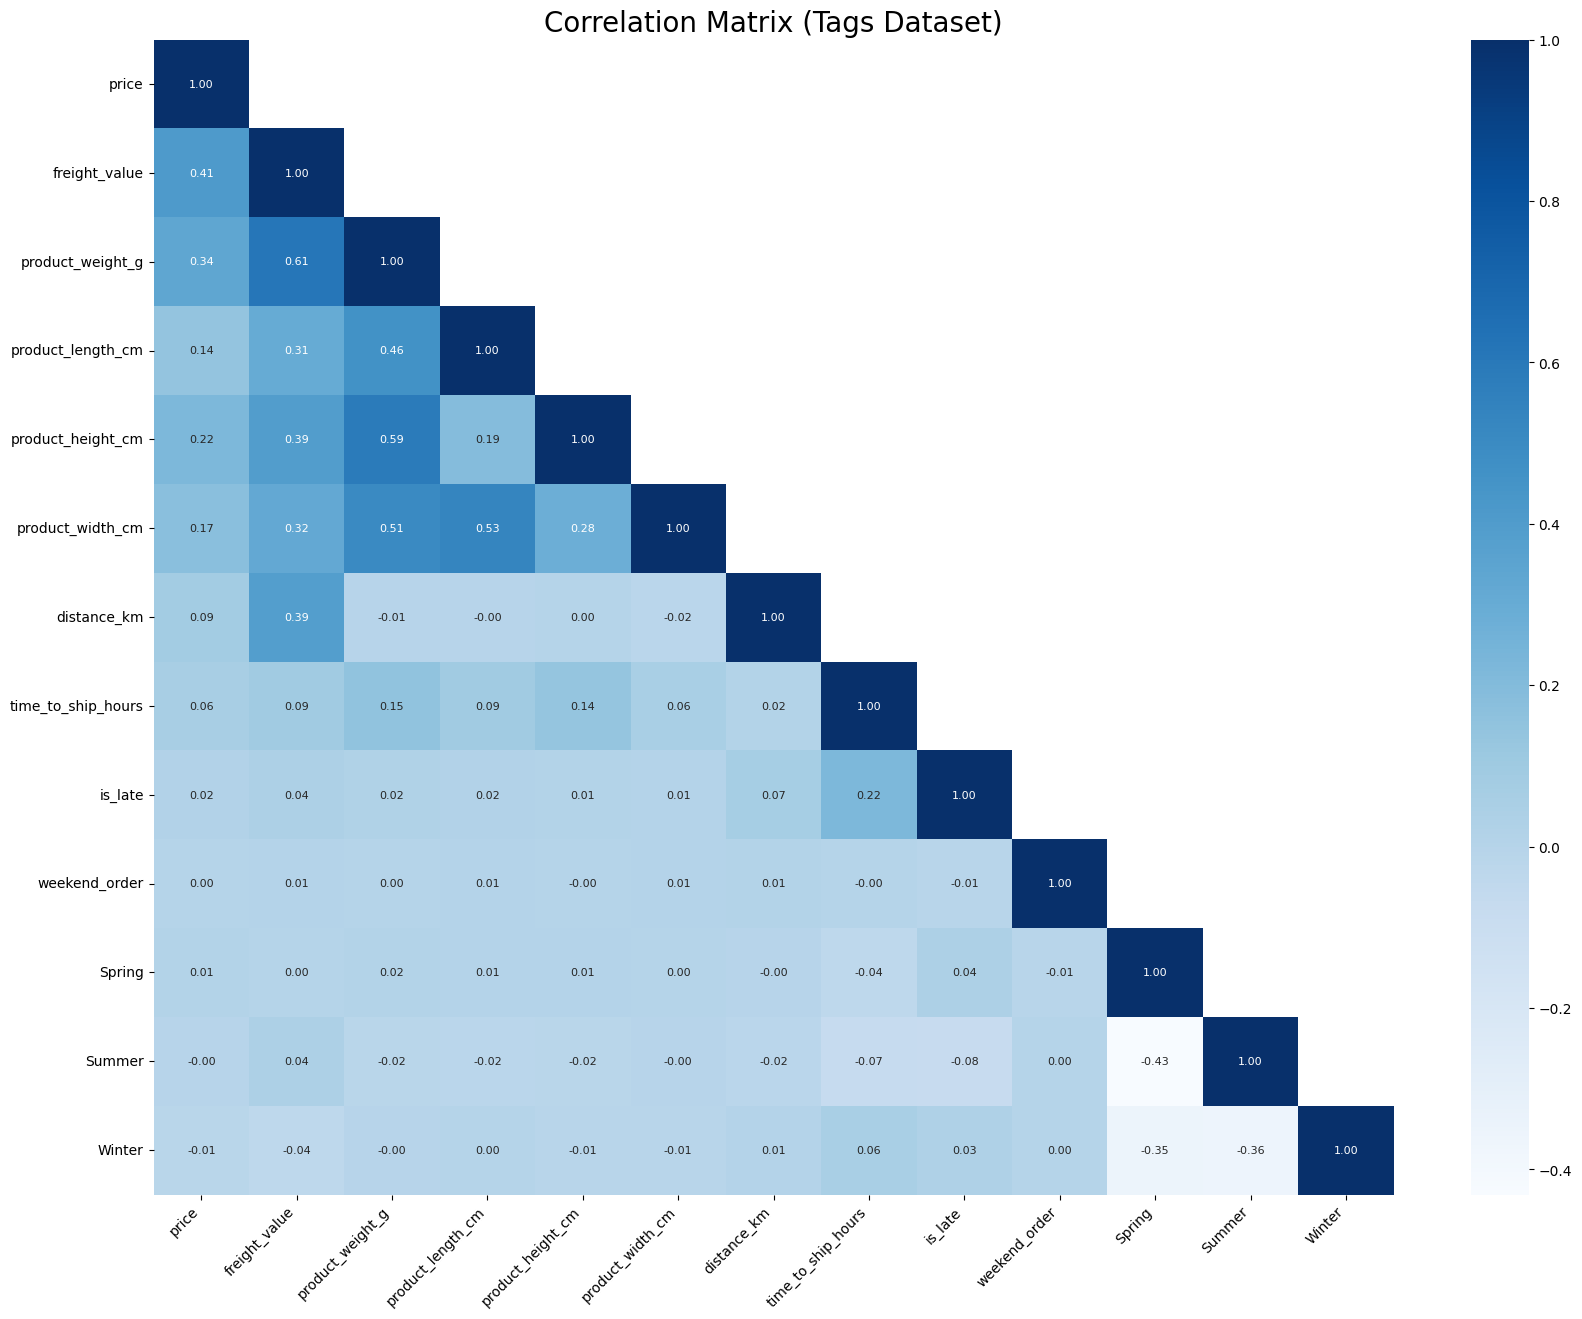

In [42]:
# Calculate the correlation matrix
correlation_matrix = data.drop(columns= ["customer_location", "seller_location", "season",
                       "product_volume", "customer_unique_id", "customer_zip_code_prefix",
                       "order_item_id", "product_id", "shipping_limit_date","seller_zip_code_prefix"]).corr()

# Generate a mask for the upper triangle without the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Set the figure size
plt.figure(figsize=(20, 15))

# Create the heatmap with the mask
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cbar=True, cmap="Blues", annot_kws={'size': 8}, mask=mask)

# Add a title
plt.title('Correlation Matrix (Tags Dataset)', fontsize=20)

# Rotate x-axis and y-axis tick labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

## Train/Test Split

- We are checking for missing values in the features and outcome.

In [43]:
data.isna().sum()

customer_unique_id           0
customer_zip_code_prefix     0
order_item_id                0
product_id                   0
shipping_limit_date          0
price                        0
freight_value                0
product_weight_g            18
product_length_cm           18
product_height_cm           18
product_width_cm            18
seller_zip_code_prefix       0
customer_location            0
seller_location              0
distance_km                  0
time_to_ship_hours           0
product_volume              18
season                       0
is_late                      0
weekend_order                0
Spring                       0
Summer                       0
Winter                       0
dtype: int64

- Given that the number of missing values is small, we drop them

In [44]:
data.dropna(inplace= True)

In [45]:
# Define X as the feature set and y as the outcome variable

X = data.drop(columns=['is_late', "customer_location", "seller_location", "season",
                       "product_volume", "customer_unique_id", "customer_zip_code_prefix",
                       "order_item_id", "product_id", "shipping_limit_date",
                       "price", "seller_zip_code_prefix"])  # Features

y = data['is_late']  # Outcome variable

In [46]:
X.head()

,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,distance_km,time_to_ship_hours,weekend_order,Spring,Summer,Winter
0,8.72,500.0,19.0,8.0,13.0,18.063837,56.795833,0,0,0,0
1,22.76,400.0,19.0,13.0,19.0,856.292580,11.109167,0,0,1,0
2,19.22,420.0,24.0,19.0,21.0,514.130333,4.910278,0,0,1,0
3,27.20,450.0,30.0,10.0,20.0,1822.800366,89.900000,1,0,0,0
4,8.72,250.0,51.0,15.0,15.0,30.174037,21.434722,0,0,0,1


In [47]:
y.value_counts()

is_late
0    99466
1     8626
Name: count, dtype: int64

In [48]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

## Random Forest Model

AUC of the Random Forest model: 0.721
Matthews Correlation Coefficient for Random Forest model: 0.176

Accuracy on training set: 0.7211
Accuracy on test set: 0.7163

Accuracy of the Random Forest model: 0.716

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83     19894
           1       0.15      0.57      0.24      1725

    accuracy                           0.72     21619
   macro avg       0.55      0.65      0.53     21619
weighted avg       0.89      0.72      0.78     21619



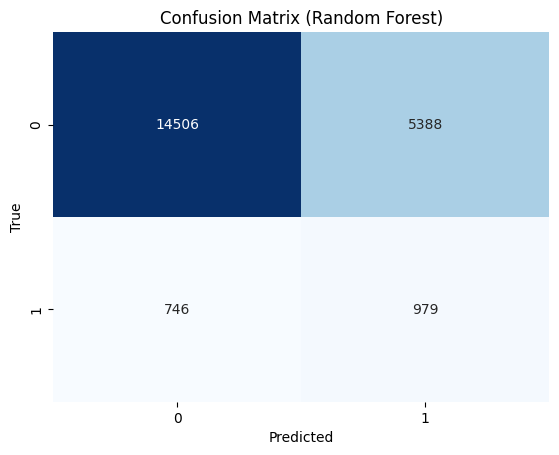

In [49]:
# Step 1: Building Random Forest Classifier with chosen parameters
clf = RandomForestClassifier(class_weight="balanced",
                             n_estimators=300,
                             max_samples=0.05,
                             max_features="sqrt",
                             max_depth = 5,
                             criterion='gini')

# Step 2: Fit the model on the training data
clf.fit(X_train, y_train)

# Step 3: Make predictions on the test set
preds = clf.predict(X_test)

# Step 4: Predict probabilities for AUC calculation
y_pred_proba_rf = clf.predict_proba(X_test)[:, 1]

# Step 5: Calculate AUC and MCC
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
mcc_rf = matthews_corrcoef(y_test, preds)
print(f"AUC of the Random Forest model: {auc_rf:.3f}")
print(f"Matthews Correlation Coefficient for Random Forest model: {mcc_rf:.3f}\n")

# Step 6: Calculate training and testing set accuracy
acc_training_rf = round(clf.score(X_train, y_train), 4)
acc_test_rf = round(clf.score(X_test, y_test), 4)
print(f"Accuracy on training set: {acc_training_rf}")
print(f"Accuracy on test set: {acc_test_rf}\n")

# Step 7: Calculate accuracy on the test set
accuracy_rf = accuracy_score(y_test, preds)
print(f"Accuracy of the Random Forest model: {accuracy_rf:.3f}")

# Step 8: Classification Report
print("\nClassification Report:")
print(classification_report(y_test, preds))

# Step 9: Confusion Matrix
cm_rf = confusion_matrix(y_test, preds)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

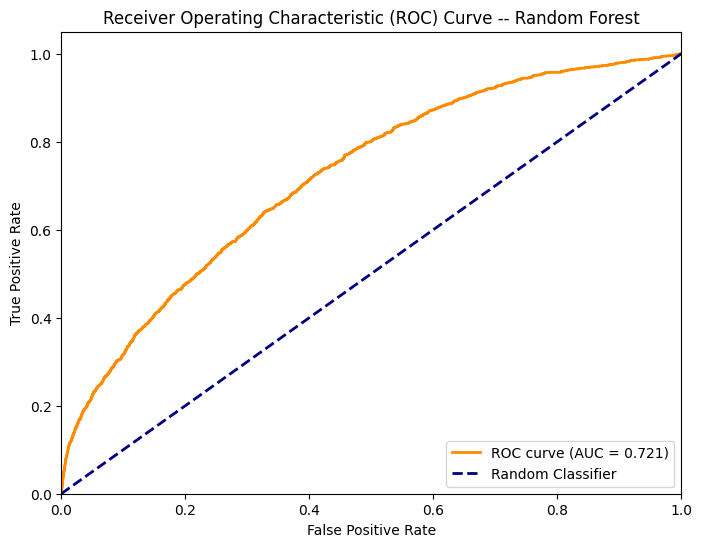

In [50]:
from sklearn.metrics import roc_curve, auc

# Calculate the FPR and TPR for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba_rf)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve -- Random Forest')
plt.legend(loc="lower right")
plt.show()

In [51]:
# Feature Importance
feature_importances_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': clf.feature_importances_
}).sort_values('Importance', ascending=False)

# Display the top 10 features by importance
print("Top Feature Importances:\n")
feature_importances_rf.head(10)

Top Feature Importances:



,Feature,Importance
6,time_to_ship_hours,0.393720
5,distance_km,0.146554
0,freight_value,0.133437
9,Summer,0.110395
1,product_weight_g,0.051391
3,product_height_cm,0.048512
2,product_length_cm,0.041874
4,product_width_cm,0.038942
8,Spring,0.016847
10,Winter,0.012389



The best predictor of late delivery is: time_to_ship_hours with an importance of 0.394


/var/folders/14/d8fzd0c94rqd5rwglx3fw6d80000gn/T/ipykernel_69746/167446974.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_rf.head(10), palette='Blues_d')


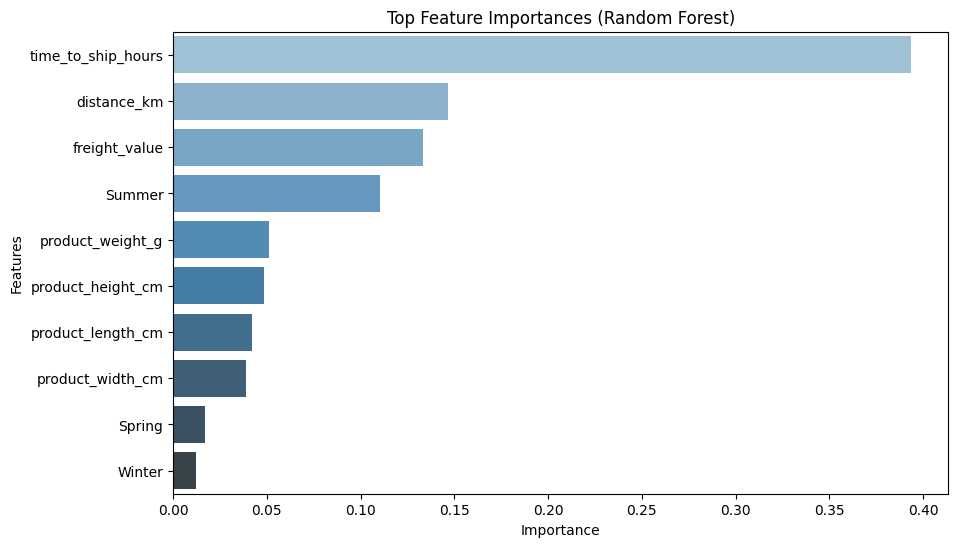

In [52]:
# Identifying the best predictor
best_predictor_rf = feature_importances_rf.iloc[0]['Feature']
print(f"\nThe best predictor of late delivery is: {best_predictor_rf} with an importance of {feature_importances_rf.iloc[0]['Importance']:.3f}")

# Plotting Top 10 Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_rf.head(10), palette='Blues_d')
plt.title('Top Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()